In [81]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

%matplotlib inline

# Load evaluation results

In [83]:
DATASET_NAMES = ["census", "wine", "credit"]
EVAL_MODELS = dict([(dn, pd.read_csv("../out/eval/{}.csv".format(dn), sep=",")) for dn in DATASET_NAMES])
EVAL_METRICS = ["Accuracy", "F1 Macro", "ROC AUC"]

DATASET_CLEAN_NAMES = {"census": "census", "wine":"wine", "credit": "credit"}

STD_MODELS = ["GBDT", "Random Forest"]
ROBUST_MODELS = ["Adv Boosting", "Robust Trees", "RF-Treant"]
ALL_MODELS = STD_MODELS + ROBUST_MODELS

# Add <code>Accuracy</code> column

In [84]:
for dataset in EVAL_MODELS:
    eval_df = EVAL_MODELS[dataset]
    eval_df['Accuracy'] = 1 - eval_df['Binary Err Rate']
    colnames = eval_df.columns.tolist()
    new_colnames = colnames[:4] + [colnames[-1]] + colnames[4:-1]
    EVAL_MODELS[dataset] = eval_df[new_colnames]

# Normalize <code>Budget</code> values

In [85]:
for dataset in EVAL_MODELS:
    eval_df = EVAL_MODELS[dataset]
    eval_df['Training Budget Norm'] = round(eval_df['Training Budget']/eval_df['Training Budget'].max(), 2)
    eval_df['Test Budget Norm'] = round(eval_df['Test Budget']/eval_df['Test Budget'].max(), 2)
    colnames = eval_df.columns.tolist()
    new_colnames = colnames[:2] + [colnames[-2]] + [colnames[2]] + [colnames[-1]] + colnames[3:-2]
    EVAL_MODELS[dataset] = eval_df[new_colnames]

In [86]:
eval_df = EVAL_MODELS['census']

In [87]:
eval_df[(eval_df["Model"] == "Adv Boosting") & (eval_df["Training Budget"] == eval_df["Test Budget"])]

,Model,Training Budget,Training Budget Norm,Test Budget,Test Budget Norm,Binary Err Rate,Accuracy,F1 Micro,F1 Macro,ROC AUC
16,Adv Boosting,30,0.25,30,0.25,0.150044,0.849956,0.849956,0.782796,0.902302
31,Adv Boosting,60,0.50,60,0.50,0.216608,0.783392,0.783392,0.690271,0.827056
46,Adv Boosting,90,0.75,90,0.75,0.202123,0.797877,0.797877,0.705353,0.824655
61,Adv Boosting,120,1.00,120,1.00,0.212406,0.787594,0.787594,0.693501,0.793357


# Plot Adversarial Boosting vs. Robust Trees vs. RF-Treant vs. GBDT vs. RF

In [88]:
def plot_atk(data, ax, metric):
    
    palette = ["#f37736", "#3385c6", "#ee2e31", "#ffc425", "#009688"]
    
    _ = sns.lineplot(x="Test Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=["o", "X", "s", "P", "D"],
                     style="Model",
                     style_order=["Random Forest", "GBDT", "RF-Treant", "Adv Boosting", "Robust Trees"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Test Attacker Budget", fontsize=18, labelpad=12)
    _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)

In [89]:
def plot_atk_dataset(df, metrics, models, axes):
    
    test_budgets = df["Test Budget"].unique()
    
    data = []
    
    for m_i, m in enumerate(metrics):
        for b_i, b in enumerate(test_budgets):
            
            data.append(df.loc[(df["Model"].isin(models)) & 
                               (df["Training Budget"] == b) & 
                               (df["Test Budget"] == b) |
                               (df["Model"] == "GBDT") |
                               (df["Model"] == "Random Forest") |
                               (df["Test Budget"] == 0)
                              ]) # & (df["Test Budget"] > 0) & (df["Test Budget"] == b)])
            
        plot_atk(pd.concat(data, axis=0), axes[m_i], m)
    
    plt.tight_layout(pad=1)

In [90]:
def plot_all_atk_datasets(eval_models, eval_metrics, robust_models, dataset_names):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=True, 
                             figsize=(18, 12))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_atk_dataset(eval_models[dataset], eval_metrics, robust_models, axes[:, j])
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname="Courier New")
    
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    
    for i, ax in enumerate(flat_axes):
        ax.get_legend().remove()
        
    fig.legend(handles=[handles[-1], handles[2], handles[3], handles[1], handles[0]],
               labels=[labels[-1], labels[2], labels[3], labels[1], labels[0]],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.06), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=5,
               markerscale=2.
              )

Generating evaluation subplot for dataset `census`...
Generating evaluation subplot for dataset `wine`...
Generating evaluation subplot for dataset `credit`...


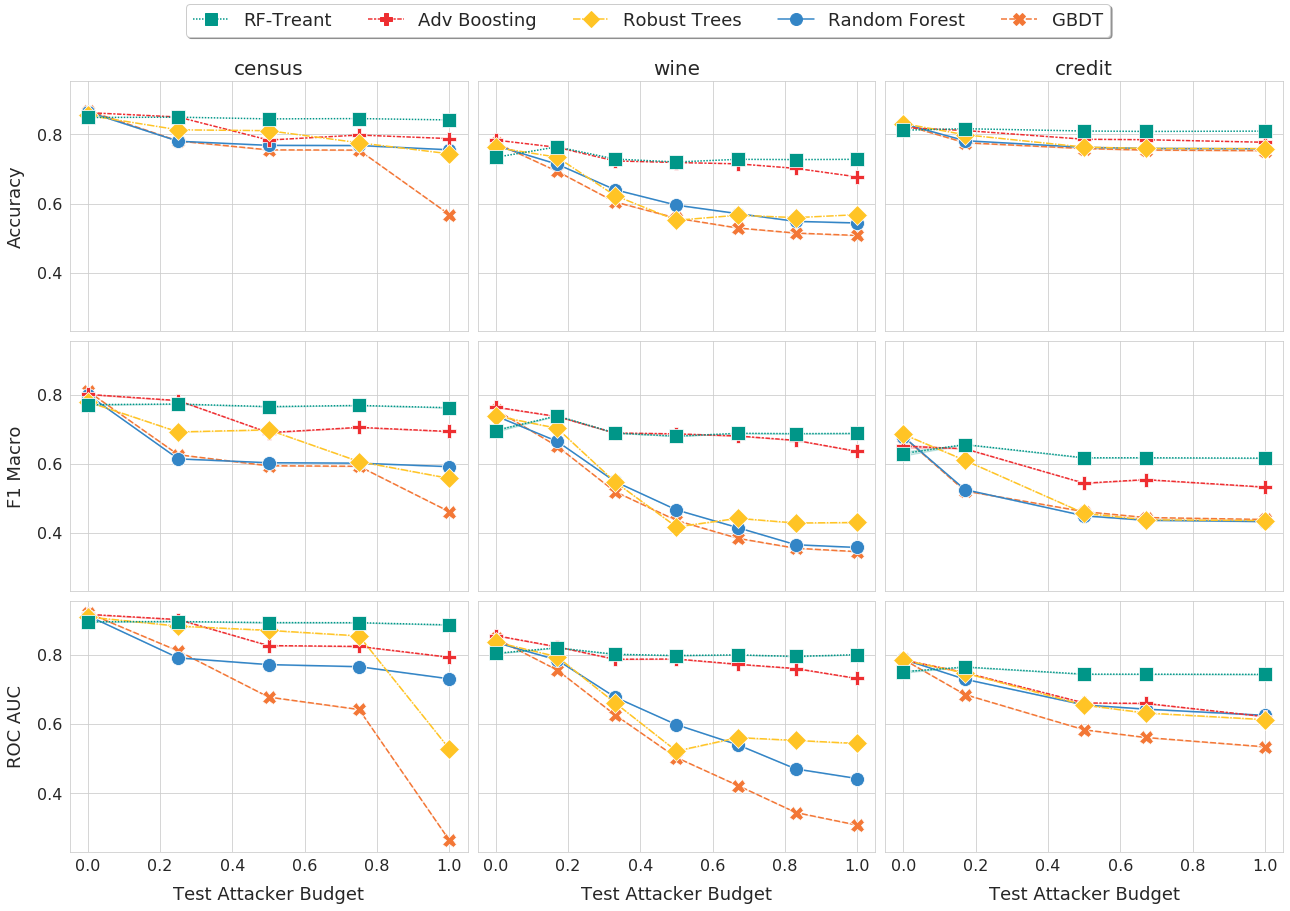

In [91]:
plot_all_atk_datasets(EVAL_MODELS, EVAL_METRICS, ALL_MODELS, DATASET_CLEAN_NAMES)

# Multiple Plots

# 1. Plot Standard GBDT vs. RF

In [92]:
def plot_std(data, ax, metric, y_lims, show_y = True):
    
    palette = ["#f37736", "#3385c6"] 
    
    _ = sns.lineplot(x="Test Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=True,
                     style="Model",
                     style_order=["Random Forest", "GBDT"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Test Attacker Budget", fontsize=18, labelpad=12)
    if show_y: _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)
    else: ax.set_ylabel('')
    _ = ax.set_ylim(y_lims)


In [93]:
def plot_std_dataset(df, metrics, std_models, axes, y_lims, show_y = True):
    
    for m_i, m in enumerate(metrics):   
        plot_std(df[(df['Model']=='GBDT') | (df['Model']=='Random Forest')], axes[m_i], m, y_lims[m_i], show_y)
    
    plt.tight_layout(pad=1)
        

In [94]:
def plot_all_std_datasets(eval_models, eval_metrics, std_models, dataset_names, y_lims):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=False, 
                             figsize=(18, 8))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_std_dataset(eval_models[dataset], eval_metrics, std_models, axes[:, j], y_lims[j], j==0)
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname='Courier New')
    
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    for ax in flat_axes:
        ax.get_legend().remove()  
    
    fig.legend(handles=handles[::-1], 
               labels=labels[::-1],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.07), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=2,
               markerscale=2.
              )

Generating evaluation subplot for dataset `census`...
Generating evaluation subplot for dataset `wine`...
Generating evaluation subplot for dataset `credit`...


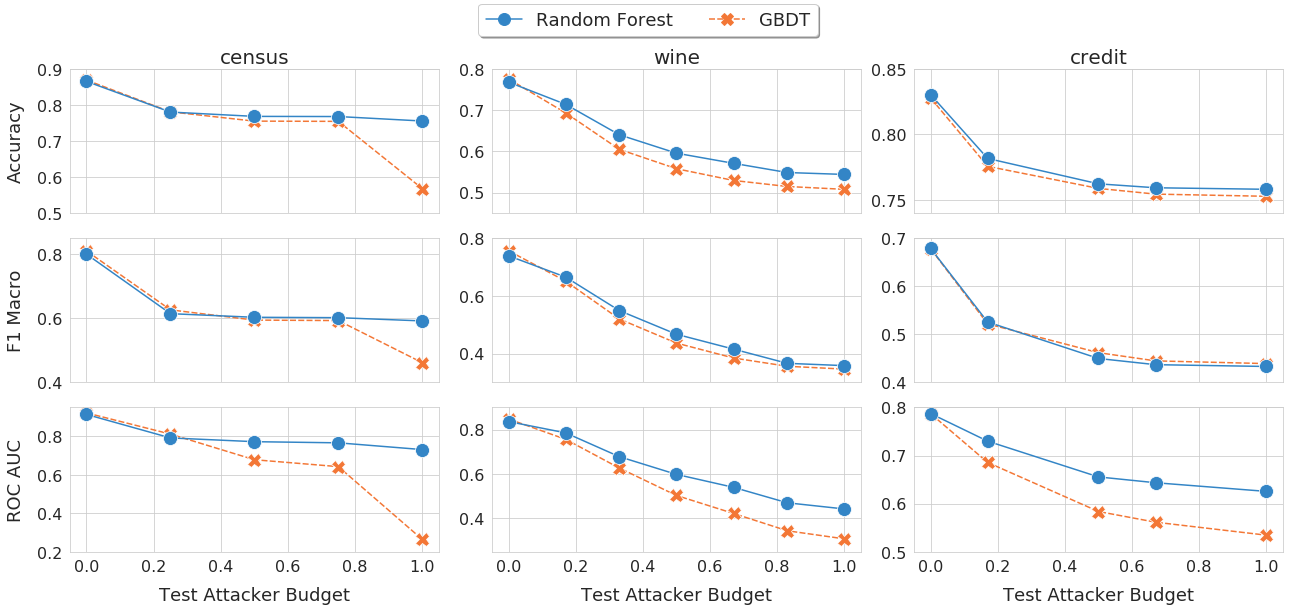

In [95]:
y_lims = [ [(.5,.9),(.4,.85),(.2,.95) ] ] + [  [(.45,.8),(.3,.8),(.25,.9) ] ]  + [  [(.74,.85),(.4,.7),(.5,.8) ] ] 

plot_all_std_datasets(EVAL_MODELS, EVAL_METRICS, STD_MODELS, DATASET_CLEAN_NAMES, y_lims)

# 2. Plot Adversarial Boosting vs. Robust Trees vs. RF-Treant

In [100]:
def plot_atk(data, ax, metric, y_lims, show_y = True):
    
    palette = ["#ee2e31", "#ffc425", "#009688"] #ee4035 "#4281a4" "#edc951"
    
    _ = sns.lineplot(x="Test Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=["s", "P", "D"],
                     style="Model",
                     style_order=["RF-Treant", "Adv Boosting", "Robust Trees"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Test Attacker Budget", fontsize=18, labelpad=12)
    if show_y: _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)
    else: ax.set_ylabel('')
    _ = ax.set_ylim(y_lims)


In [110]:
def plot_atk_dataset(df, metrics, models, axes, y_lims, show_y = True):
    
    test_budgets = df["Test Budget"].unique() # [1:]
    
    data = []
    
    for m_i, m in enumerate(metrics):
        for b_i, b in enumerate(test_budgets):
            # mask = []
            # for rm in robust_models:
                # mask.append("{} [train budget={}]".format(rm, b))
            # data.append(df.loc[(df["Model"].isin(mask)) & (df["Budget"] == b)].replace(regex=r' \[train.*\]', value=''))
            data.append(df.loc[(df["Model"].isin(models)) & (df["Training Budget"] == b) & (df["Test Budget"] > 0)]) # & (df["Test Budget"] == b)])
        
        #print (data)
        plot_atk(pd.concat(data, axis=0), axes[m_i], m, y_lims[m_i], show_y)
    
    plt.tight_layout(pad=1)

In [111]:
def plot_all_atk_datasets(eval_models, eval_metrics, robust_models, dataset_names, y_lims):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=False, 
                             figsize=(18, 12))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_atk_dataset(eval_models[dataset], eval_metrics, robust_models, axes[:, j], y_lims[j], j==0)
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname="Courier New")
    
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    
    for i, ax in enumerate(flat_axes):
        ax.get_legend().remove()
#         I was trying to adjust x_lim for the `census` dataset but set_xlim/set_ylim has a "global" effect
#         since we are using sharex=True and sharey=True
#         print(ax.get_xlim())
#         if i % 3 == 0:
#             ax.set_xlim(0.2, 1.05)
#         print(ax.get_xlim())
        
    fig.legend(handles=[handles[2], handles[0], handles[1]], 
               labels=[labels[2], labels[0], labels[1]],
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.06), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=3,
               markerscale=2.
              )

Generating evaluation subplot for dataset `census`...
Generating evaluation subplot for dataset `wine`...
Generating evaluation subplot for dataset `credit`...


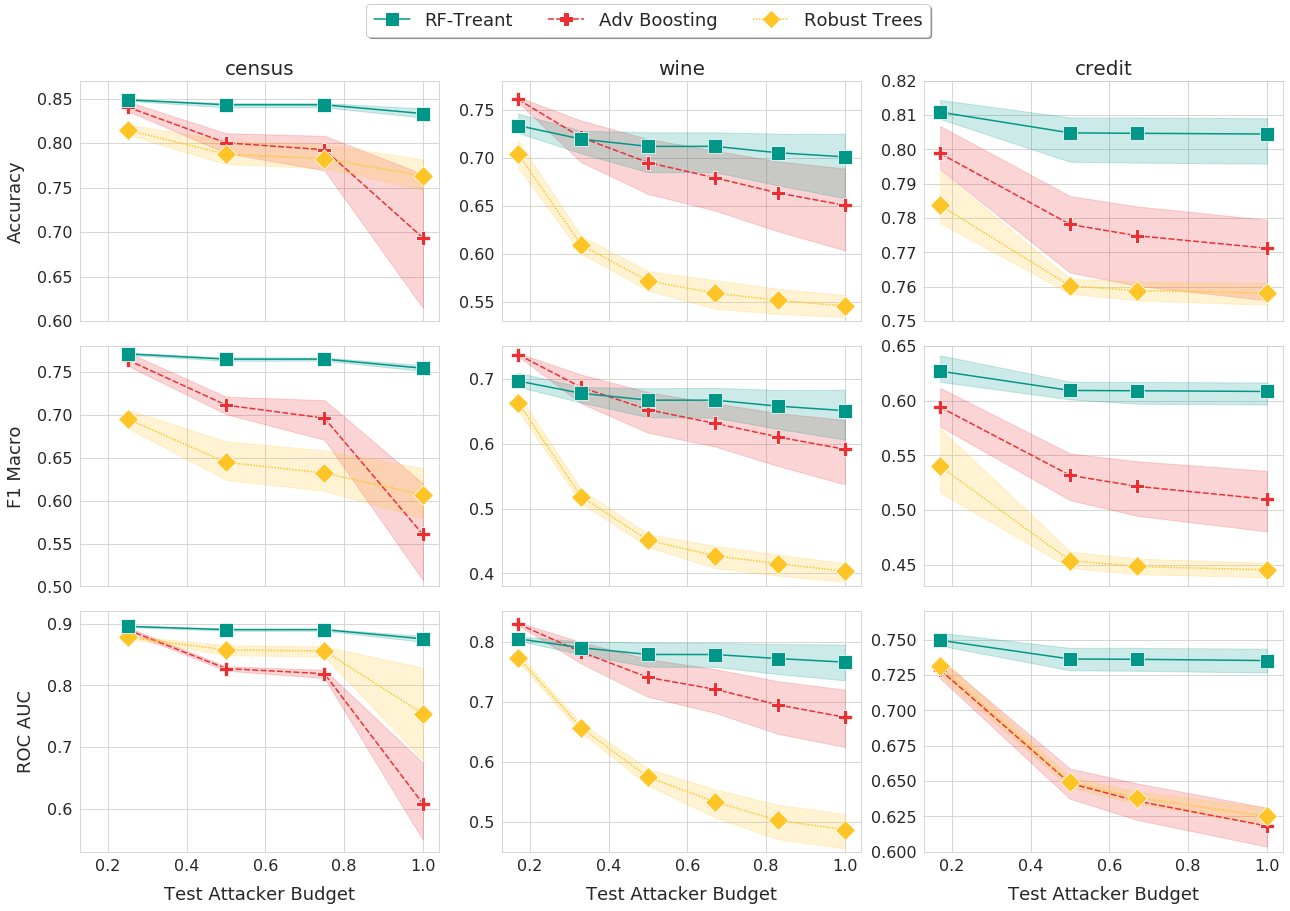

In [117]:
y_lims = [ [(0.6,.87),(0.5,.78),(.53,.92) ] ] + [  [(.53,.78),(.38,.75),(.45,.85) ] ]  + [  [(.75,.82),(.43,.65),(.6,.77) ] ] 

plot_all_atk_datasets(EVAL_MODELS, EVAL_METRICS, ROBUST_MODELS, DATASET_CLEAN_NAMES, y_lims)

# 3. Efficiency-Robustness Tradeoff

In [ ]:
def plot_tradeoff(data, ax, metric):
    
    palette = ["#f37736", "#3385c6", "#ee2e31", "#ffc425", "#009688"]
    #palette = ["#f37736", "#3385c6", "#009688"] 
    
    _ = sns.lineplot(x="Training Budget Norm", 
                     y= metric, 
                     hue="Model",
                     markers=True,
                     style="Model",
                     #style_order=["Random Forest", "GBDT", "RF-Treant"],
                     style_order=["Random Forest", "GBDT", "RF-Treant", "Adv Boosting", "Robust Trees"],
                     data=data,
                     markersize=14,
                     palette=palette,
                     ax=ax
                    )
    
    _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
    _ = ax.set_xlabel("Train Attacker Budget", fontsize=18, labelpad=12)
    _ = ax.set_ylabel(metric, fontsize=18, labelpad=12)
    # draw two horizontal lines for standard models (GBDT and RF)
    _ = ax.axhline(y=data[data["Model"] == "Random Forest"][metric].values[0], ls="-", lw=.5, color="#3385c6")
    _ = ax.axhline(y=data[data["Model"] == "GBDT"][metric].values[0], ls="--", lw=.5, color="#f37736")
    _ = ax.set_ylim(0.6, 0.95)

In [ ]:
def plot_tradeoff_dataset(df, metrics, models, axes):
    
    for m_i, m in enumerate(metrics):   
        plot_tradeoff(df[(df["Model"].isin(models)) & (df['Test Budget']==0)], axes[m_i], m)
    
    plt.tight_layout(pad=1)

In [ ]:
def plot_all_tradeoff_datasets(eval_models, eval_metrics, models, dataset_names):
    
    sns.set_style("whitegrid")
    
    fig, axes = plt.subplots(nrows=3, 
                             ncols=3, 
                             sharex=True, 
                             sharey=True, 
                             figsize=(18, 10))
    
    for j, dataset in enumerate(eval_models):
        print("Generating evaluation subplot for dataset `{}`...".format(dataset))
        plot_tradeoff_dataset(eval_models[dataset], eval_metrics, models, axes[:, j])
        _ = axes[0, j].set_title(dataset_names[dataset], fontsize=20, fontname="Courier New")
        
    flat_axes = axes.flatten()
    handles, labels = flat_axes[0].get_legend_handles_labels()
    # remove legend title
    handles = handles[1:]
    labels = labels[1:]
    
    
    for ax in flat_axes:
        ax.get_legend().remove()

    fig.legend(handles=handles,#[handles[1], handles[0], handles[-1], handles[2], handles[3]], #handles,
               labels=labels,#[labels[1], labels[0], labels[-1], labels[2], labels[3]], # labels,
               loc='upper center', 
               bbox_to_anchor=(0.5, 1.06), 
               fontsize=18,
               fancybox=True, 
               shadow=True,
               ncol=5,
               markerscale=2.
              )

In [ ]:
MODELS = STD_MODELS + ["RF-Treant"]
MODELS = ALL_MODELS

plot_all_tradeoff_datasets(EVAL_MODELS, EVAL_METRICS, MODELS, DATASET_CLEAN_NAMES)

# OLD VERSION!!! Plot GBDT vs. RF under attack

In [ ]:
# #d11141 #00b159 #00aedb #f37735 #ffc425

def plot_standard(eval_df, dataset_name, eval_metrics, ax):
    sns.set_style("whitegrid")
    atk_budgets = eval_df['Budget Norm'].unique()
    #fig, ax = plt.subplots(1, 1, figsize=(6,6))
    palette = ['#d11141', '#00b159'] #, '#00aedb', '#f37735', '#ffc425', '#8874a3']
    palette = ['#00aedb', '#d11141']
    ls = ['-', '--']
    markers=['^', 's','o']
    for i, metric in enumerate(eval_metrics):
        _ = sns.lineplot(x="Budget Norm", 
                        y= metric, 
                        hue="Model",
                        markers=[markers[i], markers[i]],
                        style="Model",
                        style_order=["GBDT", "Random Forest"],
                        palette=palette, #[i*2:i*2+2],
                        data=eval_df[(eval_df['Model']=='GBDT') | (eval_df['Model']=='Random Forest')],
                        markersize=12,
                        ax=ax)
        #_ = ax.set_xlabel("attacker's budget", fontsize=18, labelpad=12)
        #_ = ax.set_ylabel("metric", fontsize=18, labelpad=12)
        _ = ax.tick_params(axis = 'both', which = 'major', labelsize = 16)
        _ = ax.set_title(dataset_name, fontsize=22)
        legend_elements = [Line2D([0], [0], color='#00aedb', lw=2),
                           Line2D([0], [0], color='#d11141', lw=2, ls="--"),
                           Line2D([0], [0], color='black', lw=1, marker="^", markersize=8), #, mew=3),
                           Line2D([0], [0], color='black', lw=1, marker="s", markersize=8),
                           Line2D([0], [0], color='black', lw=1, marker="o", markersize=8)
                          ]
        
        leg = ax.legend(title='Models', 
                      loc='best', 
                      handles=legend_elements, 
                      labels=['GBDT', 'Random Forest', 'Accuracy', 'F1 Macro', 'ROC AUC'],
                      borderpad=1,
                      fontsize=16)
        leg.get_title().set_fontsize(16)

In [ ]:
def plot_all_standard(eval_dict, eval_metrics):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(18,8))
    i = 0
    for dataset_name in eval_dict:
        print("Plotting GBDT vs. RF under attack for dataset `{}`...".format(dataset_name))
        plot_standard(eval_dict[dataset_name], dataset_name, eval_metrics, axes[i])
        axes[i].set_xlabel("attacker's budget", fontsize=20, labelpad=12)          
        if i == 0:
            axes[i].set_ylabel("metric", fontsize=20, labelpad=12)
        i += 1
    plt.tight_layout(pad=2.5)
    

In [ ]:
plot_all_standard(EVAL_MODELS, EVAL_METRICS)